## Introduction

A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary 
Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a 
cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant 
Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. 
The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. 

These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and 
their properties.


## Info regarding data

The dataset contains 3 folders: yes, no and pred which contains 3060 Brain MRI Images.

Folder	Description:


Yes	The folder yes contains 1500 Brain MRI Images that are tumorous


No	The folder no contains 1500 Brain MRI Images that are non-tumorous

## Imports

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from sklearn import svm, linear_model, ensemble, neighbors, tree

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.colors
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Upload Data

In [18]:
# Define folder paths
folder_path = "C:/Users/Casey/Downloads/Brain Tumor Data"
tumor_path = os.path.join(folder_path, "yes")
no_tumor_path = os.path.join(folder_path, "no")

# Function to get a list of image filenames in a folder
def get_image_filenames(folder):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    return [file for file in os.listdir(folder) if file.lower().endswith(image_extensions)]

# Get the list of image filenames
tumor_files = get_image_filenames(tumor_path)
no_tumor_files = get_image_filenames(no_tumor_path)

resizing images to the same dimention 224 and setting up a robust data preprocessing pipeline

In [19]:
# Initialize dataset and label lists
dataset = []
label = []

# Define the input size for resizing images
INPUT_SIZE = 224  # You can adjust this size as needed

# For images labeled with no
for image_name in no_tumor_files:
    image_path = os.path.join(no_tumor_path, image_name)
    image = cv2.imread(image_path)
    if image is not None:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(0)
    else:
        print(f"Warning: Image {image_path} not found or could not be read.")

# For images labeled with yes
for image_name in tumor_files:
    image_path = os.path.join(tumor_path, image_name)
    image = cv2.imread(image_path)
    if image is not None:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        image = image.resize((INPUT_SIZE, INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)
    else:
        print(f"Warning: Image {image_path} not found or could not be read.")

# Convert lists to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Print shapes of dataset and label to verify
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (3000, 224, 224, 3)
Label shape: (3000,)


## Data Augmentation

setting up data preprocessing and augmentation pipelines for training and validating

In [26]:
# Shuffle dataset and labels together to maintain correspondence
indices = np.arange(len(dataset))
np.random.shuffle(indices)
dataset = dataset[indices]
label = label[indices]

# Data generators
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=90,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

# Assuming you have the dataset and label ready, you would typically use flow method instead of flow_from_directory
train_generator = train_datagen.flow(dataset, label, subset='training', batch_size=32)
test_generator = test_datagen.flow(dataset, label, subset='validation', batch_size=16)

## Split Data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

## Normalization

normalizing the pixel values of the images in X_train and X_test arrays to a range between 0 and 1. 

In [31]:
X_train = X_train/255.0
X_test = X_test/255.0

Displaying the shapes of training and test data arrays to verify dimensions before model training.

In [32]:
print('X_train Shape: ', X_train.shape)
print('X_test Shape: ', X_test.shape)
print('y_train Shape: ', y_train.shape)
print('y_test Shape: ', y_test.shape)

X_train Shape:  (2400, 224, 224, 3)
X_test Shape:  (600, 224, 224, 3)
y_train Shape:  (2400,)
y_test Shape:  (600,)


## Converting string to categorical

In [38]:
# Convert target values to one-hot vectors
y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

## Building CNN Model

Building CNN model to predict wheater an image is tumor or not build a Convolutional Neural Network (CNN) model to predict whether an image contains 
a tumor or not. 

In [44]:
model=Sequential()

# Add an Input layer with the desired input shape
model.add(Input(shape=(INPUT_SIZE, INPUT_SIZE, 3)))

# First convolutional layer with 32 filters of size 3x3, ReLU activation
model.add(Conv2D(32, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Max pooling layer with pool size 2x2
model.add(Conv2D(32, (3,3),activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second convolutional layer with 32 filters of size 3x3, ReLU activation, and He uniform kernel initializer
model.add(Conv2D(64, (3,3),activation='relu', kernel_initializer='he_uniform'))
# Max pooling layer with pool size 2x2
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to convert 2D matrix to a vector
model.add(Flatten())
# Dense (fully connected) layer with 64 neurons and ReLU activation
model.add(Dense(64,activation='relu'))
# Dropout layer with 50% dropout rate to reduce overfitting
model.add(Dropout(0.5))
# Output layer with 2 neurons (for binary classification) and softmax activation
model.add(Dense(2,activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,768,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,797,730 (10.67 MB)

 Trainable params: 2,797,730 (10.67 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=10, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, verbose=True)

history = model.fit(X_train, y_train_encoded, batch_size=16, epochs=100, verbose=1, shuffle=False ,
                     validation_data=(X_test, y_test_encoded), callbacks=[model_es, model_rlr])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 274ms/step - accuracy: 0.7316 - loss: 0.6512 - val_accuracy: 0.8583 - val_loss: 0.3555 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.8659 - loss: 0.3219 - val_accuracy: 0.9117 - val_loss: 0.2121 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.9318 - loss: 0.1935 - val_accuracy: 0.9100 - val_loss: 0.2312 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 213ms/step - accuracy: 0.9456 - loss: 0.1426 - val_accuracy: 0.9467 - val_loss: 0.1452 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.9621 - loss: 0.1254 - val_accuracy: 0.9667 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 218ms/step - accuracy: 0.9804 - loss: 0.0638 - val_accuracy: 0.9600 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 221ms/step - accura

visualizing and comparing the training and validation performance (accuracy and loss) of a CNN model across multiple epochs.

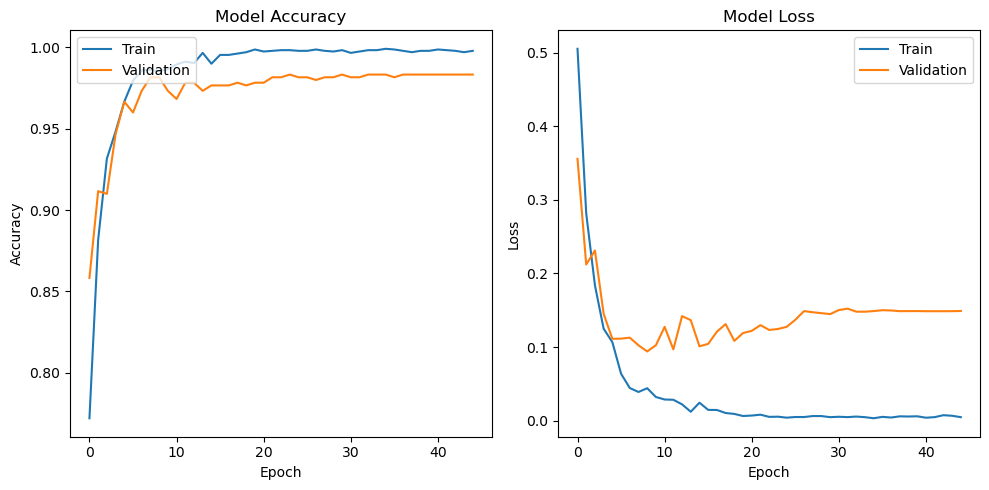

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot training and validation accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')

# Save the figure
plt.savefig('plot CNN-2.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

The trained model is used to predict the class probabilities for the test dataset

In [67]:
# Make predictions softmax
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Get the index of the maximum value

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Val Accuracy = %.4f' % accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Val Accuracy = 0.9833


The accuracy of the model is 0.98 which indicates model is performing well and it would be the best fit model for this data

In [68]:
print("Classification Report:\n",classification_report(y_test,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       287
           1       0.98      0.98      0.98       313

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



The classification report demonstrates that the model performs exceptionally well, with high precision, recall, and F1-scores of 0.98 for both classes.

below code generates a confusion matrix heatmap for visualizing the performance of a classification model. 

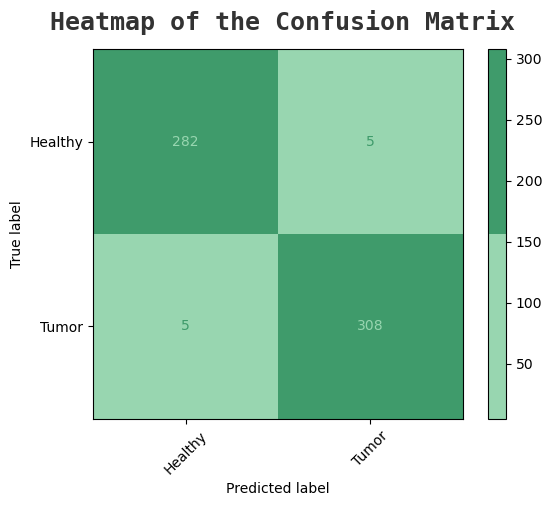

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are defined somewhere earlier in your code

# Define the custom color map
custom_colors = ['#98D6B0', '#3F9B6B']
custom_cmap = matplotlib.colors.ListedColormap(custom_colors)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a display object with the custom color map
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots()
disp.plot(cmap=custom_cmap, ax=ax)

# Set the title and axis labels
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', y=0.92, x=0.10, alpha=0.8)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure
plt.savefig('CM_CNN-2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


calculates and plots the Receiver Operating Characteristic (ROC) curves for each class in a multi-class classification problem, using the predicted 
probabilities from a trained model. It also computes the Area Under the Curve (AUC) score for each class. 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


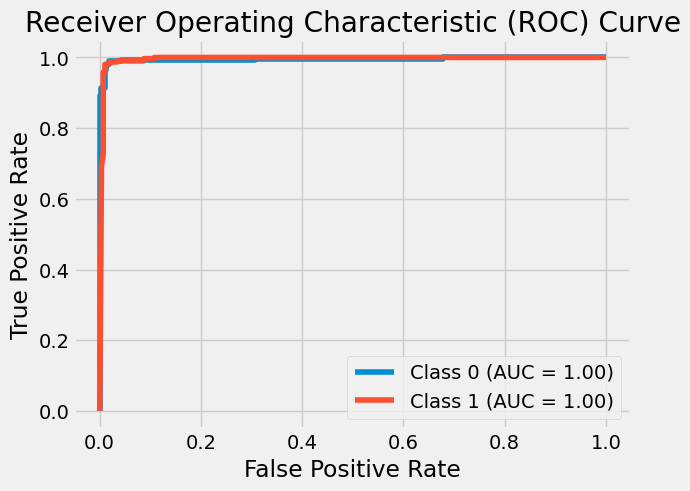

In [84]:
# Compute predicted probabilities for each class
y_probs = model.predict(X_test)

# Ensure that the target labels Y_test are in a 2-dimensional format
if len(y_test.shape) == 1:
    Y_test = np.eye(len(np.unique(y_test)))[y_test.astype(int)]

# Compute the ROC curve and AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(Y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_probs[:, i])
    roc_auc[i] = roc_auc_score(Y_test[:, i], y_probs[:, i])

# Plot the ROC curve for each class
plt.figure()
for i in range(Y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Set the title and axis labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Save the figure
plt.savefig('ROC CNN-2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

generates a 4x4 grid of images (a total of 16 images) from a test dataset (X_test). Each image is displayed with its actual and predicted labels, 
which are either "No Tumor" or "Tumor". 

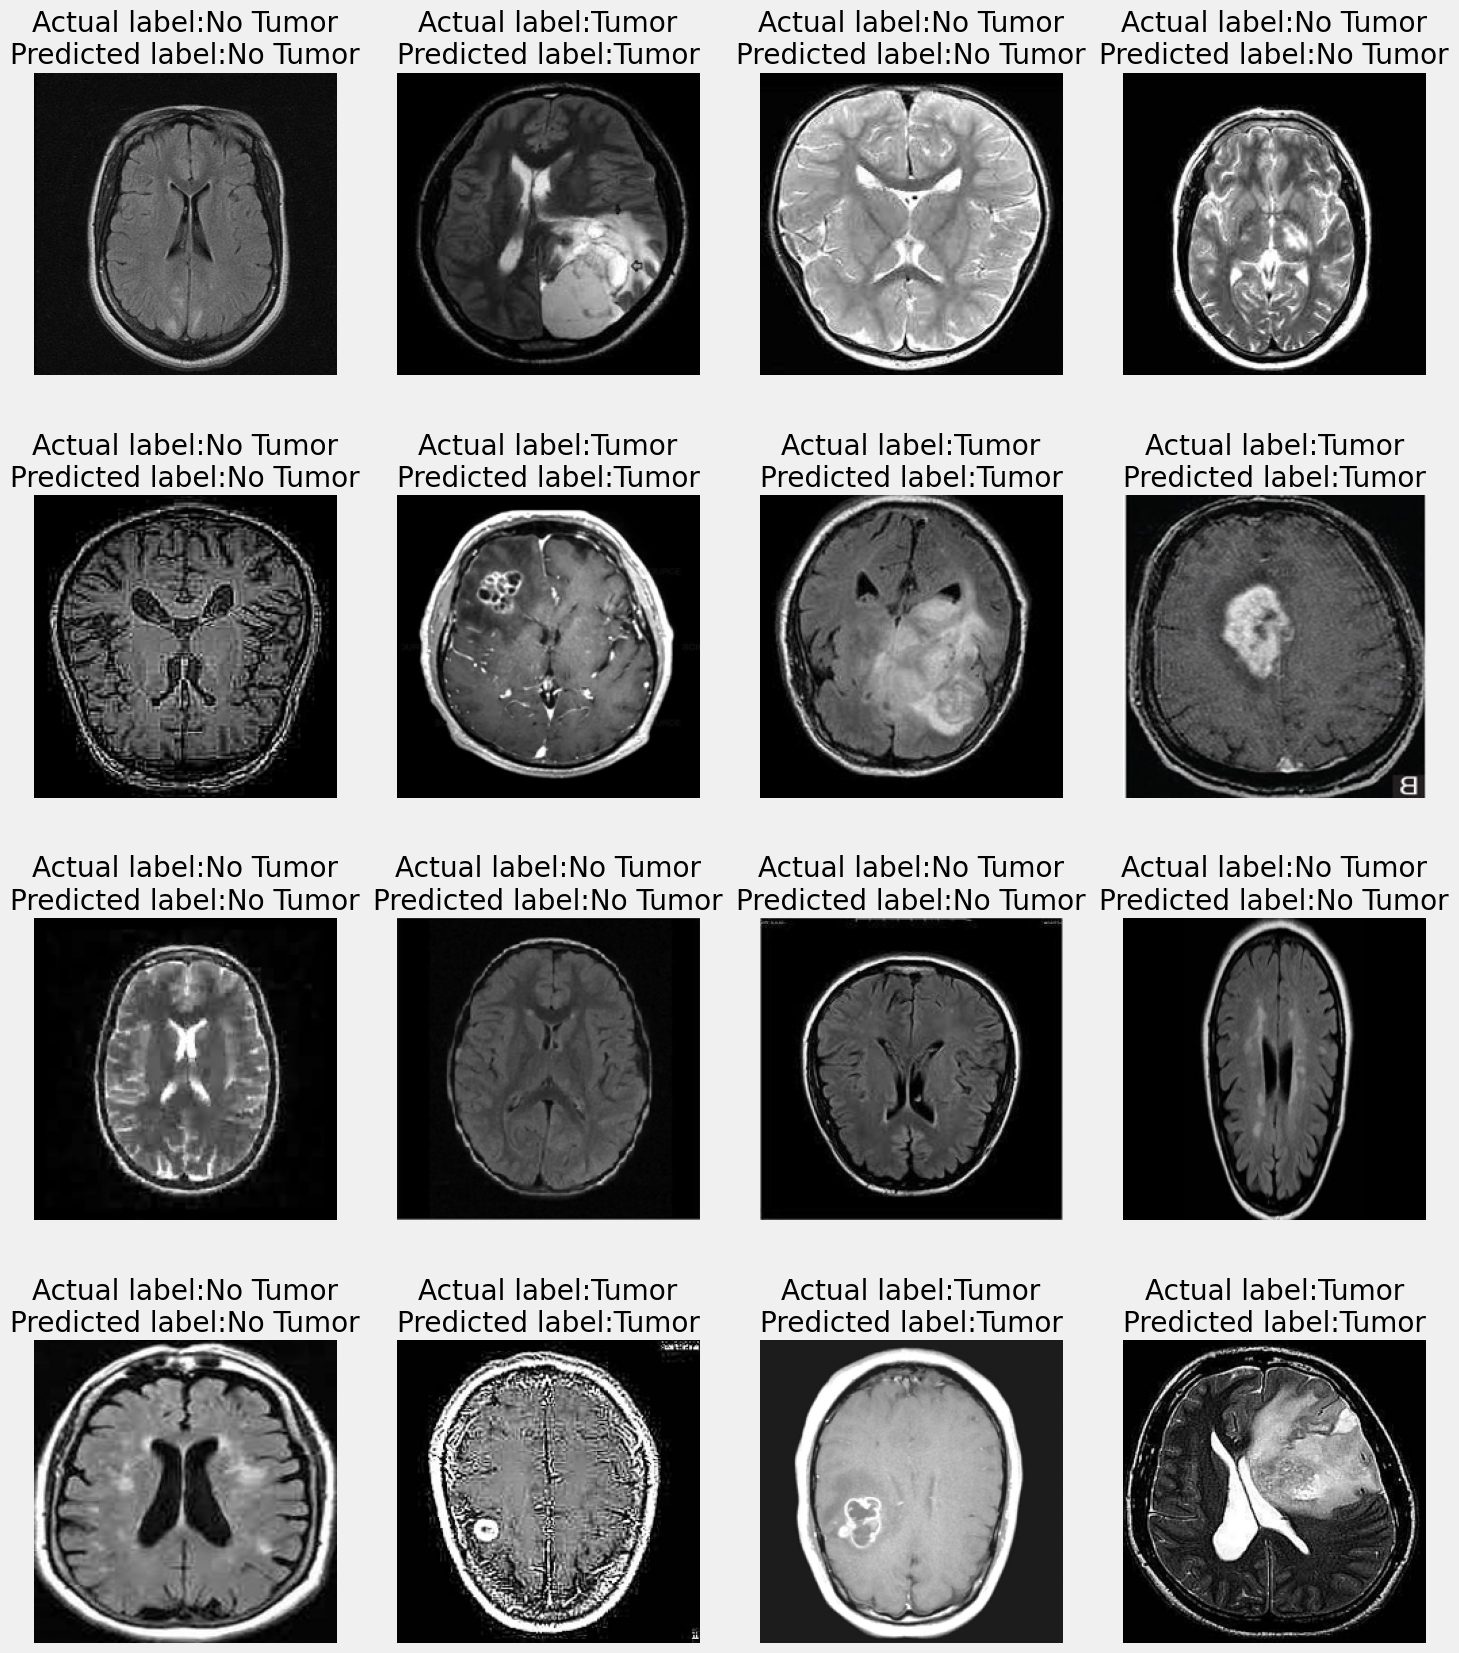

In [86]:
# Define the class labels for the tumor classification
class_labels=["No Tumor","Tumor"]
# Set the figure size for the plot
plt.figure(figsize=(16, 20))

# Loop over the first 16 test images
for i in range(16):
    # Create a subplot in a 4x4 grid
    plt.subplot(4,4,i+1)
    # Display the i-th test image
    plt.imshow(X_test[i])
    plt.title(f"Actual label:{class_labels[y_test[i]]}\nPredicted label:{class_labels[y_pred[i]]}",color = 'black')
    plt.axis("off")

## Predict the images

defines a function predict(img_path) that takes the file path of an image as input, preprocesses it, and predicts whether the image depicts a 
healthy brain or a tumor-affected brain using a pre-trained model.

In [78]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    
    # Define the class labels
    labels = ['Healthy Brain', 'Tumor Brain']
    
    plt.figure(figsize=(12, 12))
    plt.style.use('fivethirtyeight')
    
    # Load and preprocess the image
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    
    # Make predictions
    predictions = model.predict(img)
    probs = list(predictions[0])

     plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


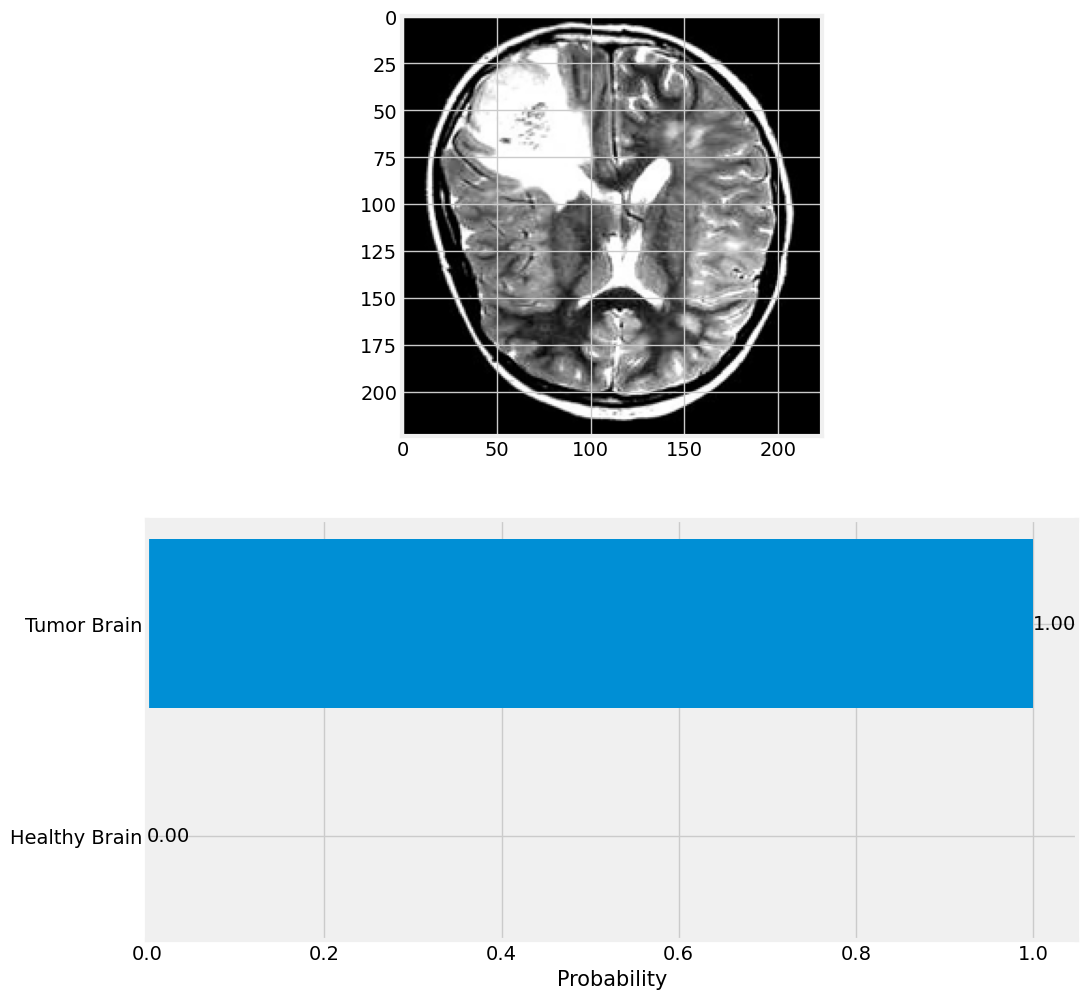

In [80]:
predict("C:/Users/Casey/Downloads/Brain Tumor Data/yes/y0.jpg")

Model predicted the image correctly, it was a tumored image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


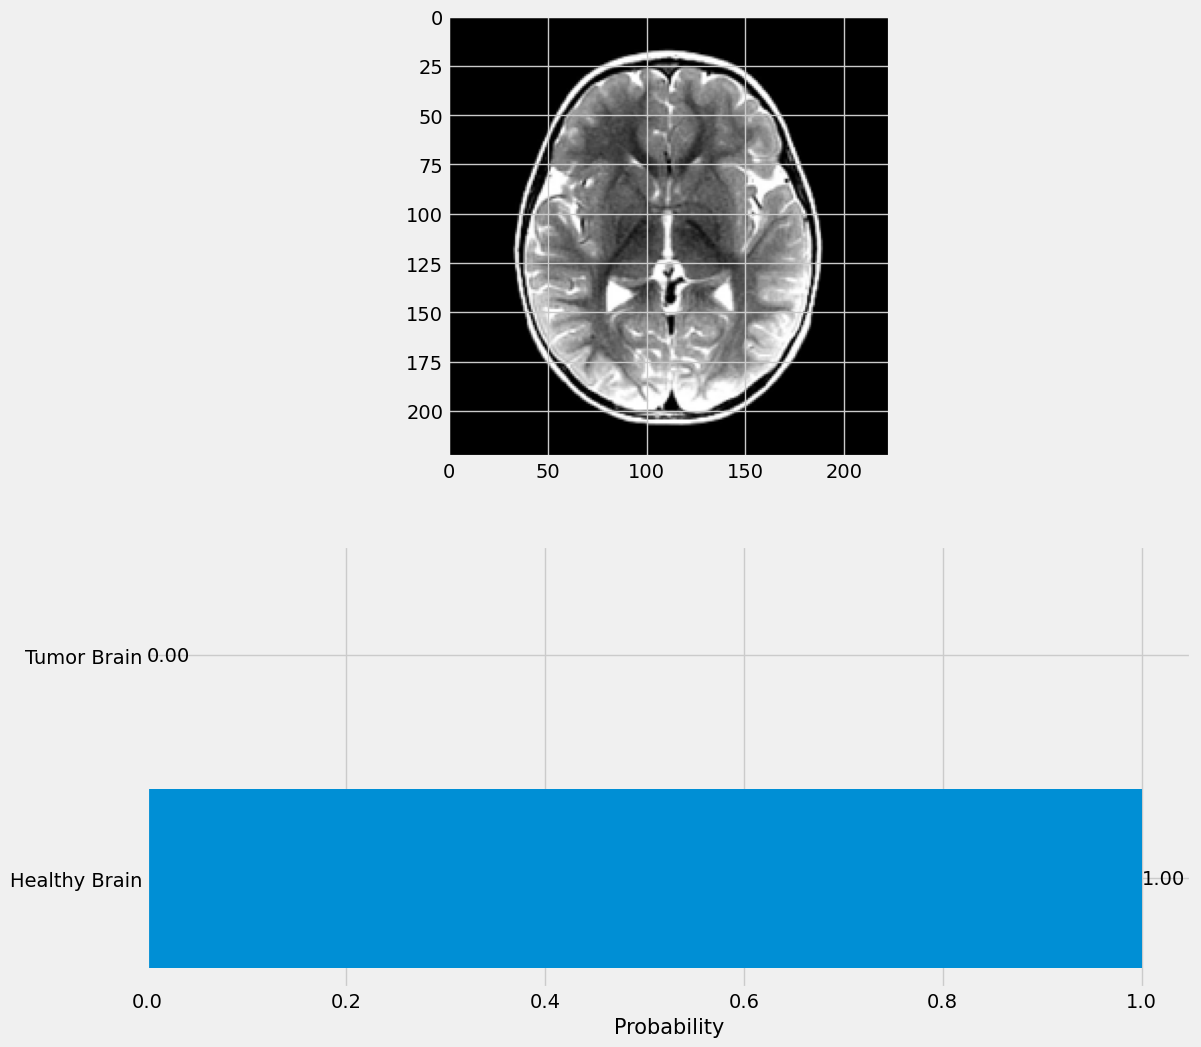

In [82]:
predict("C:/Users/Casey/Downloads/Brain Tumor Data/no/no0.jpg")

Again, model predicted the image correctly, it was a non-tumor image

## Conclusion

The predict function effectively demonstrates the capability of a pre-trained model to classify brain images as either "Healthy Brain" or "Tumor Brain".
By preprocessing the input image and generating a visual representation of the model's predictions, the function provides a user-friendly way to
interpret the results. The use of horizontal bar charts helps to clearly communicate the confidence levels of the predictions.

## Next Steps

#### Model Evaluation:

Evaluate the model on a larger test dataset to measure its accuracy, precision, recall, and F1 score. This will help in understanding the model's
performance and identifying any areas of improvement.


#### Data Augmentation:

Implement data augmentation techniques to increase the diversity of the training dataset. This can help improve the model's generalization capabilities and robustness.


#### Fine-Tuning the Model:

Fine-tune the pre-trained model using a specific dataset of brain images to improve its accuracy. This can be achieved by adjusting hyperparameters, using a different architecture, or employing techniques like transfer learning.


#### Error Analysis:

Conduct a thorough error analysis to identify common misclassifications and their potential causes. This will provide insights into how the model can be further improved.


#### Cross-Validation:

Use cross-validation techniques to ensure that the model performs consistently across different subsets of the data. This can help in validating the model's robustness.


#### User Interface Development:

Develop a user-friendly interface for the predict function, allowing users to upload images and receive predictions easily. This can be in the form of a web application or a standalone software tool.

    
#### Integration with Clinical Workflow:

Explore opportunities to integrate the model into clinical workflows for real-time brain tumor detection. This would involve collaborating with healthcare professionals to ensure the tool meets clinical standards and provides actionable insights.

    
#### Model Interpretability:

Implement methods to increase the interpretability of the model, such as Grad-CAM or other visualization techniques. This can help clinicians understand why the model is making certain predictions, thereby increasing trust and adoption.

    
#### Regular Updates and Maintenance:

Keep the model updated with new data and improvements to maintain its accuracy and relevance. Regular maintenance will ensure that the model continues to perform well as new brain imaging data becomes available.


By following these next steps, the predictive model can be continuously improved, making it a more reliable and valuable tool for brain tumor detection in clinical settings.